### Test formation of quasicrystal by projection of high-dimentional unit cells

In [1]:
%matplotlib inline
from neurotools.nlab import *
import sys
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import math

Loading nlab namespace
Could not locate the spectrum module, please install it
Multitaper methods will not work
Could not locate the spectrum module, please install it
Multitaper methods will not work


In [2]:
def showtri(pp):
    pp = np.float64(pp)
    if pp.shape[1]<3:
        raise ValueError('Must have at least 3 points in 2 x N array')
    # Create the Triangulation; no triangles so Delaunay triangulation created.
    triang = tri.Triangulation(pp[0],pp[1])
    # Plot the triangulation.
    plt.figure(figsize=(15,15))
    plt.gca().set_aspect('equal')
    plt.triplot(triang, 'ko-', lw=0.5,markersize=0)
    plt.title('triplot of Delaunay triangulation')
    #xlim(-K*2,K*2)
    #ylim(-K*2,K*2)

In [133]:
# Dimensionality
M = 7
# Raster scale 
K = 7
# Raster resolution
S = 5
# Unit vectors; make explicit no using complex this time
phases  = arange(M)*pi/M
rescale = sqrt(2.0/M) # correction for non orthogonality
units   = np.float128([cos(phases),sin(phases)])*rescale

# Define the M-D basis
basis = np.int32(np.eye(M))

# Define units step vectors in all M dimensions
steps = np.concatenate([basis,-basis]).T

# Unit vectors in 2D for local neighborhood
units2D = units.dot(steps)
units2D

array([[ 0.53452248,  0.48158812,  0.33326932,  0.11894244, -0.11894244,
        -0.33326932, -0.48158812, -0.53452248, -0.48158812, -0.33326932,
        -0.11894244,  0.11894244,  0.33326932,  0.48158812],
       [ 0.0,  0.23192061,  0.41790651,  0.52112089,  0.52112089,
         0.41790651,  0.23192061,  0.0, -0.23192061, -0.41790651,
        -0.52112089, -0.52112089, -0.41790651, -0.23192061]], dtype=float128)

### Check that hyperlattice basis is unitary

In [134]:
units.dot(units.T)

array([[ 1.0,  2.1148719e-17],
       [ 2.1148719e-17,  1.0]], dtype=float128)

In [135]:
units.T.dot(units)

array([[ 0.28571429,  0.25741968,  0.17813994,  0.06357741, -0.06357741,
        -0.17813994, -0.25741968],
       [ 0.25741968,  0.28571429,  0.25741968,  0.17813994,  0.06357741,
        -0.06357741, -0.17813994],
       [ 0.17813994,  0.25741968,  0.28571429,  0.25741968,  0.17813994,
         0.06357741, -0.06357741],
       [ 0.06357741,  0.17813994,  0.25741968,  0.28571429,  0.25741968,
         0.17813994,  0.06357741],
       [-0.06357741,  0.06357741,  0.17813994,  0.25741968,  0.28571429,
         0.25741968,  0.17813994],
       [-0.17813994, -0.06357741,  0.06357741,  0.17813994,  0.25741968,
         0.28571429,  0.25741968],
       [-0.25741968, -0.17813994, -0.06357741,  0.06357741,  0.17813994,
         0.25741968,  0.28571429]], dtype=float128)

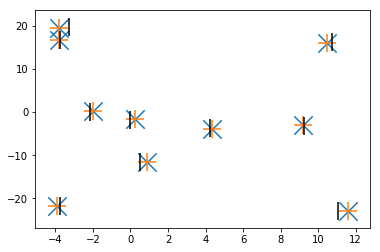

In [136]:
points = random.randn(2,10)*10
scatter(*points,marker='x',s=340)

projected = units.dot(units.T.dot(points))
scatter(*projected,marker='+',s=340)

quantized = units.dot(np.round(units.T.dot(points)))
scatter(*quantized,marker='|',s=340,color='k')

### Try distance to plane approach

Hyperpoints within 1/2 sqrt(M) should be good?

In [137]:
def cartesian_product(*arrays):
    '''
    https://stackoverflow.com/questions/11144513/
    numpy-cartesian-product-of-x-and-y-array-points-into-single-array-of-2d-points
    '''
    la = len(arrays)
    dtype = numpy.result_type(*arrays)
    arr = numpy.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(numpy.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

In [138]:
r = arange(-K,K+1)
points = cartesian_product(*([r]*M))

distance = abs(sum((points-points.dot(units.T).dot(units))**2,axis=1))

hist(distance,100);
pok = distance<M
sum(pok)

points = points[pok,:]
points.shape

p2d = units.dot(points.T)*rescale

figure(figsize=(15,15))
scatter(*p2d)
force_aspect()
showtri(p2d)

MemoryError: 

In [ ]:
pp = np.float64(p2d)
if pp.shape[1]<3:
    raise ValueError('Must have at least 3 points in 2 x N array')
# Create the Triangulation; no triangles so Delaunay triangulation created.
triang = tri.Triangulation(pp[0],pp[1])
# Plot the triangulation.
plt.figure(figsize=(15,15))
plt.gca().set_aspect('equal')
plt.triplot(triang, 'ko-', lw=0.5,markersize=0)
plt.title('triplot of Delaunay triangulation')
xlim(-K,K)
ylim(-K,K)

# Compute edge lengths of triangles
xy = np.array([triang.x,triang.y])
z = np.array(triang.x) + 1j*np.array(triang.y)
tedgs = triang.triangles[:,[0,1,2,0]]
tpts = z[tedgs]
tedgelen = abs(diff(tpts,axis=1))
elens = tedgelen.ravel()

# Expected lengths of rhombus diagonals
ph = phases[1:M//2+1]
cp = cos(ph)
sp = sin(ph)
elen = sqrt(sp**2+(1-cp)**2)
elen = np.append([1],elen) # add unit length

# Determine edge length ID (identifies tri shape)
near = abs(tedgelen[:,:,None]-elen[None,None,:])
edgeid = argmin(near,axis=2)

# Handle equilateral triangles specially
unit = find(abs(elen-1)<1e-3)
redund = unit!=0
if any(redund):
    replace = unit[redund]
    for id in replace:
        edgeid[edgeid==id] = 0

# Ok?
tok = sum(edgeid==0,axis=1)>=2
category = sum(edgeid,axis=1)
print('%0.2f%% triangles OK'%(100*mean(tok)))

# Generate a color map for triangles
cmapdata = neurotools.color.isolum_data
cmapdata.shape,
NC = (np.max(edgeid)+1)
cmap = cmapdata[(arange(NC)*cmapdata.shape[0])//NC,:]

In [ ]:
hist(elens)

In [ ]:
tris = []
lins = []

njobs = len(tok)
for index in find(tok):
    t = triang.triangles[index]
    c = category[index]
    color = cmap[c%NC]
    pp = np.array([triang.x[t],triang.y[t]]).T
    p = plt.Polygon(pp,facecolor=color,edgecolor=color) ## PP is 3x2
    tris.append(p)
    if index%5==0:
        sys.stdout.write('\rTriangles prepared %0.1f%% '%((index+1)*100./njobs))
        sys.stdout.flush()
    
ee = triang.edges
ex = triang.x[ee]
ey = triang.y[ee]
dx = diff(ex,axis=1)
dy = diff(ey,axis=1)
dl = sqrt(dx*dx+dy*dy)
eps = 1e-3
unit = abs(dl-1)
eok = unit<eps
njobs = len(eok)
for eindex in find(eok):
    l = plt.Line2D(ex[eindex],ey[eindex],color='k',lw=0.9)
    lins.append(l)
    if eindex%5==0:
        sys.stdout.write('\rEdges prepared %0.1f%%        '%((eindex+1)*100./njobs))
        sys.stdout.flush()

In [ ]:
fig = figure(figsize=(50,50))
ax  = gca()    
#xlim(lima,limb)
#ylim(lima,limb)
xlim(-K,K)
ylim(-K,K)

force_aspect()

njobs = len(tok)
for index,p in enumerate(tris):
    ax.add_patch(p)
    if index%5==0:
        sys.stdout.write('\rTriangles rendered %0.1f%% '%((index+1)*100./njobs))
        sys.stdout.flush()

njobs = len(eok)
for eindex,l in enumerate(lins):
    ax.add_line(l)
    if eindex%5==0:
        sys.stdout.write('\rEdges rendered %0.1f%%        '%((eindex+1)*100./njobs))
        sys.stdout.flush()

sys.stdout.write('\nShowing final result...\n')
sys.stdout.flush()
plt.draw_all()